In [ ]:
# import needed libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive
import matplotlib.image as mpimg
import pandas as pd
from IPython import display
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import cv2
from zipfile import ZipFile 
from pathlib import Path
import sys
import tensorflow as tf
from PIL import Image
from PIL import ImageChops
import zipfile
from zipfile import ZipFile
from google.colab.patches import cv2_imshow

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Extract ZIP Dataset




In [ ]:
file_name = '/content/drive/My Drive/orl_dataset.zip'
zf = ZipFile(file_name, 'r')
zf.extractall('/content/drive/My Drive/orl_dataset')
zf.close()

In [ ]:
def read_pgm(pgmf):
    """Return a raster of integers from a PGM as a list of lists."""
    pgmf.readline()
    (width, height) = [int(i) for i in pgmf.readline().split()]
    depth = int(pgmf.readline())
    assert depth <= 255

    raster = []
    for y in range(width):
        row = []
        for y in range(height):
            row.append(ord(pgmf.read(1)))
        raster.append(row)
    return raster

In [ ]:
path_folder = '/content/drive/My Drive/orl_dataset'
files = os.listdir(path_folder)
files.remove(files[0])
files.remove(files[0])
print(len(files))
print(files)

40
['s1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's3', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's4', 's40', 's5', 's6', 's7', 's8', 's9']


**Read Dataset**

In [ ]:
data_matrix = np.zeros((400,10304))
labels = np.zeros((400,))
k = 0
for i in range(len(files)):
  path_file = path_folder + '/' + files[i]
  pgms = os.listdir(path_file)
  name = files[i]
  name = name.replace(name[0],'')
  for j in range(len(pgms)):
    f = open(path_file+'/'+pgms[j], 'rb')
    r = read_pgm(f)
    r = np.array(r)
    r = np.true_divide(r, 255)
    r = r.reshape(r.shape[0]*r.shape[1],)
    data_matrix[k] = r
    labels[k] = int(name)
    k = k+1
print(data_matrix.shape)
print(labels.shape)

(400, 10304)
(400,)


**Split 50 %** **for train and 50% for test**

In [ ]:
x_train = np.zeros((200,10304))
y_train = np.zeros((200,))
x_test = np.zeros((200,10304))
y_test = np.zeros((200,))
train = 0
test = 0
for i in range(data_matrix.shape[0]):
  if (i % 2 != 0):
    x_train[train] = data_matrix[i]
    y_train[train] = labels[i]
    train = train+1
  else:
    x_test[test] = data_matrix[i]
    y_test[test] = labels[i]
    test = test+1
print(x_train.shape, ' ', y_train.shape,' ', x_test.shape, ' ', y_test.shape)

(200, 10304)   (200,)   (200, 10304)   (200,)


**Split 70%** **for train and 30% for test**

In [ ]:
x_train = np.zeros((280,10304))
y_train = np.zeros((280,))
x_test = np.zeros((120,10304))
y_test = np.zeros((120,))
train = 0
test = 0
var = 0
for i in range(data_matrix.shape[0]):
  if (var <= 6):
    x_train[train] = data_matrix[i]
    y_train[train] = labels[i]
    train = train+1
  else:
    x_test[test] = data_matrix[i]
    y_test[test] = labels[i]
    test = test+1
  var = var + 1
  if (var == 10):
    var = 0
print(x_train.shape, ' ', y_train.shape,' ', x_test.shape, ' ', y_test.shape)

(280, 10304)   (280,)   (120, 10304)   (120,)


**Find projection matrix using PCA**

In [ ]:
#PCA
def pca(D, alpha):
  mean = np.mean(D,axis = 0)
  Z = D - mean.transpose()
  n = Z.shape[0]
  covariance = (np.dot(Z.transpose(), Z)) / n
  eig_values, eig_vectors = np.linalg.eigh(covariance)
  eig_values = np.diag(eig_values[::-1])
  eig_vectors = eig_vectors[:,::-1]
  eig_values_sum = np.sum(eig_values)
  thresold = alpha * eig_values_sum
  fraction = eig_values[0][0]
  i = 1
  while(fraction < thresold):
    fraction += eig_values[i][i]
    i = i + 1
  projection_matrix = eig_vectors[:, :i]
  return projection_matrix

**Project train and test sets**

In [ ]:
def PCA_Neighbors(x_train, y_train, x_test, y_test, projection, neighbors=1):
  A_train1 = np.dot(x_train,projection)
  A_test1 = np.dot(x_test,projection)
  #scaler = StandardScaler()
  #scaler.fit(A_train1)
  #A_train1 = scaler.transform(A_train1)
  #A_test1 = scaler.transform(A_test1)
  classifier = KNeighborsClassifier(n_neighbors= neighbors)
  classifier.fit(A_train1, y_train)
  y_pred = classifier.predict(A_test1)
  return y_pred

In [ ]:
alpha = np.array([0.8,0.85,0.9,0.95])
neighbors = np.array([1,3,5,7])
projection_matrix = pca(x_train,alpha[3])

In [ ]:
y_pred = PCA_Neighbors(x_train, y_train, x_test, y_test, projection_matrix, neighbors[0])

In [ ]:
from sklearn import metrics
#alpha = 0.8, k = 1
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.91


In [ ]:
from sklearn import metrics
#alpha = 0.8, k = 3
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.78


In [ ]:
from sklearn import metrics
#alpha = 0.8, k = 5
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.76


In [ ]:
from sklearn import metrics
#alpha = 0.8, k = 7
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.765


In [ ]:
from sklearn import metrics
#alpha = 0.85, k = 1
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.88


In [ ]:
from sklearn import metrics
#alpha = 0.85, k = 3
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.755


In [ ]:
from sklearn import metrics
#alpha = 0.85, k = 5
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.735


In [ ]:
from sklearn import metrics
#alpha = 0.85, k = 7
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.705


In [ ]:
from sklearn import metrics
#alpha = 0.9, k = 1
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.84


In [ ]:
from sklearn import metrics
#alpha = 0.9, k = 3
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.71


In [ ]:
from sklearn import metrics
#alpha = 0.9, k = 5
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.615


In [ ]:
from sklearn import metrics
#alpha = 0.9, k = 7
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.59


In [ ]:
from sklearn import metrics
#alpha = 0.95, k = 1
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.74


In [ ]:
from sklearn import metrics
#alpha = 0.95, k = 3
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.59


In [ ]:
from sklearn import metrics
#alpha = 0.95, k = 5
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.535


In [ ]:
from sklearn import metrics
#alpha = 0.95, k = 7
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.465


**Find projection matrix using LDA**

In [ ]:
#LDA
def LDA(D, Y):
  num_classes = int(np.max(Y))
  i = 0
  S = np.zeros((D.shape[1], D.shape[1]))
  Sb = np.zeros((D.shape[1], D.shape[1]))
  sample_means = np.mean(D, axis=0)
  while (i< (Y.shape[0])):
    dclass = D[i:i+5, :]
    mean = np.mean(dclass, axis = 0)
    Zclass = dclass - mean
    Sclass = np.dot(Zclass.transpose(), Zclass)
    S = np.add(S,Sclass)
    B = dclass.shape[0] * np.dot((mean - sample_means),(mean - sample_means).transpose())
    Sb = np.add(Sb, B)
    i = i+5 
  Sinverse_Sb = np.dot(np.linalg.inv(S), Sb)
  eig_values, eig_vectors = np.linalg.eigh(Sinverse_Sb)
  eig_vectors = eig_vectors[:,::-1]
  projection_matrix = eig_vectors[:num_classes-1,:]
  return projection_matrix

**Project train and test sets**

In [ ]:
def LDA_Neighbors(x_train, y_train, x_test, y_test, projection, neighbors=1):
  A_train1 = np.dot(x_train,projection.transpose())
  A_test1 = np.dot(x_test,projection.transpose())
  #scaler = StandardScaler()
  #scaler.fit(A_train1)
  #A_train1 = scaler.transform(A_train1)
  #A_test1 = scaler.transform(A_test1)
  classifier = KNeighborsClassifier(n_neighbors= neighbors)
  classifier.fit(A_train1, y_train)
  y_pred = classifier.predict(A_test1)
  return y_pred

In [ ]:
neighbors = np.array([1,3,5,7])
projection_matrix = LDA(x_train, y_train)

In [ ]:
y_pred = LDA_Neighbors(x_train, y_train, x_test, y_test, projection_matrix, neighbors[0])

In [ ]:
#k=1
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.79


In [ ]:
#k=3
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.69


In [ ]:
#k=5
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.685


In [ ]:
#k=7
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.63


Text(0, 0.5, 'Accuracy')

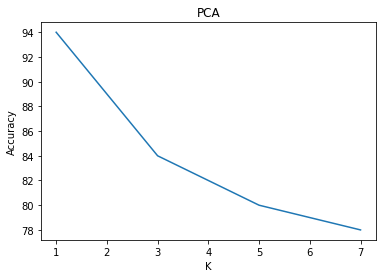

In [ ]:
#plotting 
acc = np.array([94,84, 80, 78])
plt.plot(neighbors, acc)
plt.title("PCA")
plt.xlabel("K")
plt.ylabel("Accuracy")